# New Embodiment Finetuning Tutorial

This notebook is a tutorial on how to finetune GR00T-N1 pretrained model on a new dataset. 

# 1. Lerobot SO100 Finetuning Tutorial

GR00T-N1 is accessible to everyone with various robot form-factors. Based on Huggingface's low-cost [So100 Lerobot arm](https://github.com/huggingface/lerobot/blob/main/examples/10_use_so100.md), users can finetune GR00T-N1 on their own robot via a `new_embodiment` tag.


![so100_eval_demo.gif](../media/so100_eval_demo.gif)

## Step 1: Dataset

Users can use any lerobot dataset for finetuning. In this tutorial, we will first use a sample dataset: [so100_strawberry_grape](https://huggingface.co/spaces/lerobot/visualize_dataset?dataset=youliangtan%2Fso100_strawberry_grape&episode=0)

Note that this embodiment was not used in our pretraining dataset mixture.


### First, download the dataset

```bash
huggingface-cli download --repo-type dataset youliangtan/so100_strawberry_grape --local-dir ./demo_data/so100_strawberry_grape
```

### Second, copy over the modality file

The `modality.json` file provides additional information about the state and action modalities to make it "GR00T-compatible". Copy over the `examples/so100__modality.json` to the dataset `<DATASET_PATH>/meta/modality.json`.

```bash
cp examples/so100__modality.json ./demo_data/so100_strawberry_grape/meta/modality.json
```

Then we can load the dataset using the `LeRobotSingleDataset` class.

In [ ]:
from gr00t.utils.misc import any_describe
from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.data.embodiment_tags import EmbodimentTag

dataset_path = "../demo_data/openarm.PickNPlace/" 

data_config = DATA_CONFIG_MAP["openarm"]

dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=data_config.modality_config(),
    embodiment_tag=EmbodimentTag.NEW_EMBODIMENT,
    video_backend="torchvision_av",
)

resp = dataset[7]
any_describe(resp)

/home/thomason/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-04 18:58:32.244698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 18:58:32.263122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 18:58:32.263149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register fac

Initialized dataset openarm.PickNPlace with EmbodimentTag.NEW_EMBODIMENT
{'action.gripper': 'np: [16, 1] float64',
 'action.single_arm': 'np: [16, 7] float64',
 'annotation.human.action.task_description': ['pick up the bottle from the '
                                              'counter and place it inside the '
                                              'bin.'],
 'state.gripper': 'np scalar: -0.03223468 [1, 1] float64',
 'state.single_arm': 'np: [1, 7] float64',
 'video.ego_view': 'np: [1, 480, 640, 3] uint8'}


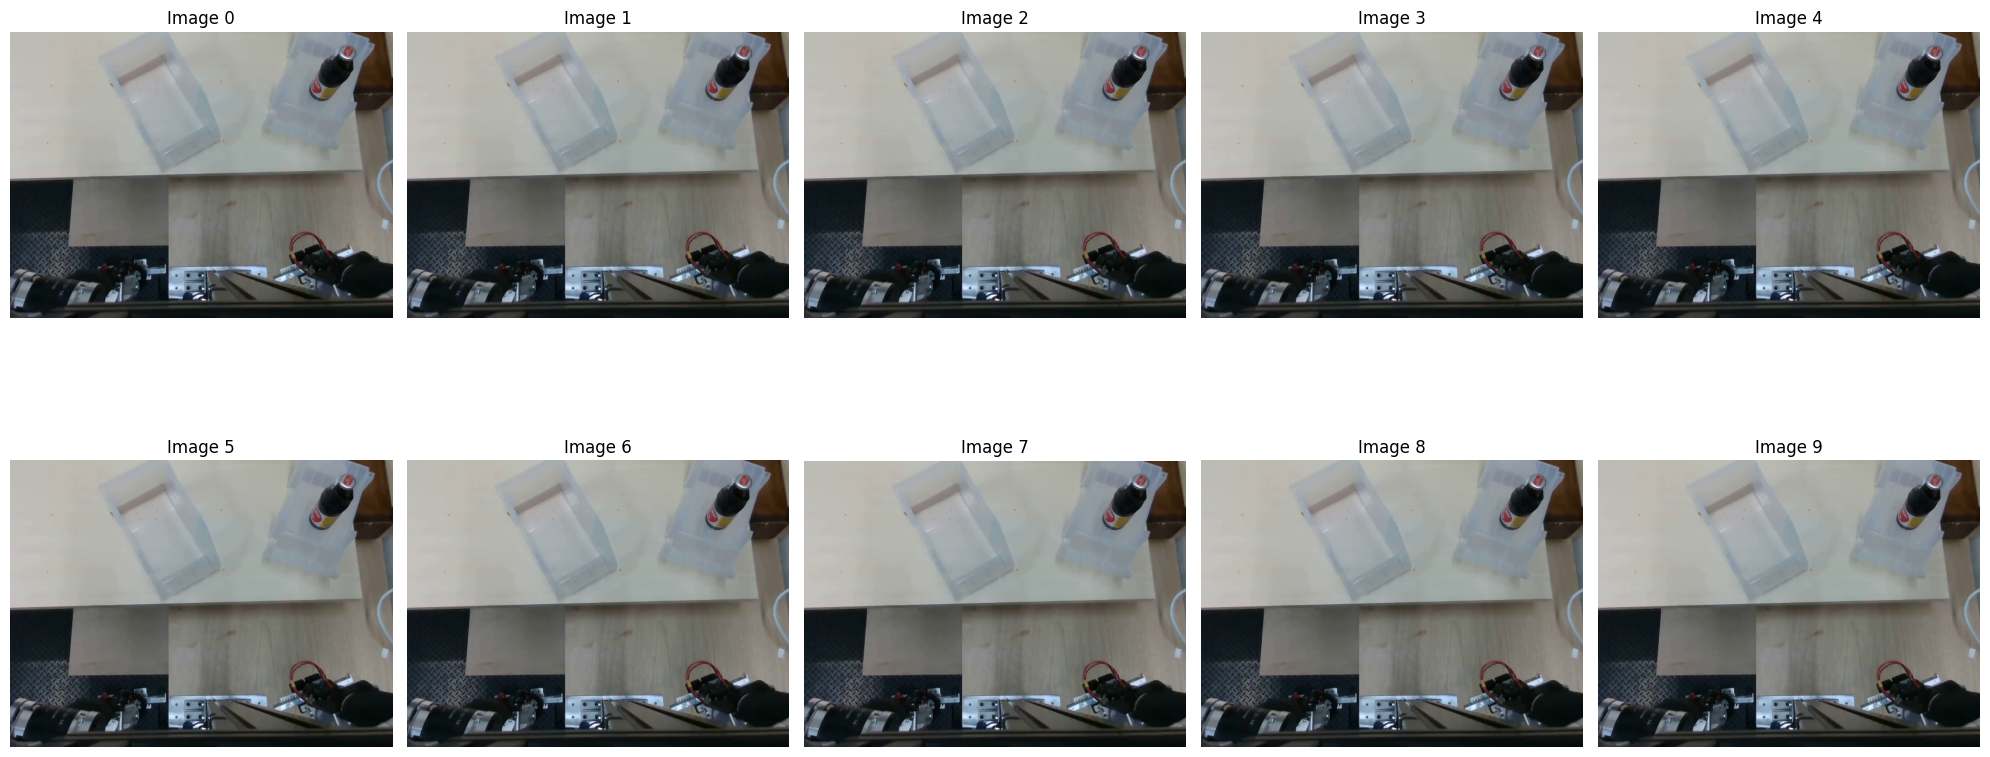

In [3]:
# visualize the dataset
# show img
import matplotlib.pyplot as plt

images_list = []

for i in range(100):
    if i % 10 == 0:
        resp = dataset[i]
        img = resp["video.ego_view"][0]
        images_list.append(img)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(images_list[i])
    ax.axis("off")
    ax.set_title(f"Image {i}")
plt.tight_layout() # adjust the subplots to fit into the figure area.
plt.show()

## Step 2: Finetuning

Finetuning can be done by using our finetuning `scripts/gr00t_finetune.py`.


```bash
python scripts/gr00t_finetune.py \
   --dataset-path ./demo_data/openarm.PickNPlace/ \
   --num-gpus 1 \
   --output-dir ~/so100-checkpoints  \
   --max-steps 2000 \
   --data-config openarm \
   --video-backend torchvision_av \
   --embodiment-tag new_embodiment
   #--no-tune-visual  not enough memory on 3090TI
```

## Step 3: Open-loop evaluation

Once the training is done, you can run the following command to visualize the finetuned policy. 

```bash
python scripts/eval_policy.py --plot \
   --embodiment_tag new_embodiment \
   --model_path ~/openarm-pnp-checkpoints \
   --data_config openarm \
  --dataset_path /datasets/openarm.PickNPlace/ \
   --video_backend torchvision_av \
   --modality_keys single_arm gripper
```

```bash
python scripts/eval_policy.py --plot \
   --embodiment_tag new_embodiment \
   --model_path ~/openarm-pnp-checkpoints/checkpoint-1500/ \
   --data_config openarm \
   --dataset_path ~/src/Isaac-GR00T/demo_data/openarm.PickNPlace/ \
   --video_backend torchvision_av \
   --modality_keys single_arm gripper \
   --steps 1000 \
   --plot
```


This is a plot after training the policy for 1.5k steps.

![openarm-1-5k-steps.png](../media/openarm-1-5k-steps.png)


After training for more steps the plot will look significantly better.


TADA! You have successfully finetuned GR00T-N1 on a new embodiment.

## Deployment

For more details about deployment, please refer to the notebook: `5_policy_deployment.md`

---

# 2. G1 Block Stacking Dataset Finetuning Tutorial

This provides a step-by-step guide on how to finetune GR00T-N1 on the G1 Block Stacking Dataset.

## Step 1: Dataset

Loading any dataset for finetuning can be done in 2 steps:
- 1.1: Defining the modality configs and transforms for the dataset
- 1.2: Loading the dataset using the `LeRobotSingleDataset` class

### Step: 1.0 Download the dataset

- Download the dataset from: https://huggingface.co/datasets/unitreerobotics/G1_BlockStacking_Dataset
- copy over the `examples/unitree_g1_blocks__modality.json` to the dataset `<DATASET_PATH>/meta/modality.json`
  - This provides additional information about the state and action modalities to make it "GR00T-compatible"
  - `cp examples/unitree_g1_blocks__modality.json datasets/G1_BlockStacking_Dataset/meta/modality.json`


**Understanding the Modality Configs**

This file provides detailed metadata about state and action modalities, enabling:

- **Separate Data Storage and Interpretation:**
  - **State and Action:** Stored as concatenated float32 arrays. The `modality.json` file supplies the metadata necessary to interpret these arrays as distinct, fine-grained fields with additional training information.
  - **Video:** Stored as separate files, with the configuration file allowing them to be renamed to a standardized format.
  - **Annotations:** Keeps track of all annotation fields. If there are no annotations, do not include the `annotation` field in the configuration file.
- **Fine-Grained Splitting:** Divides the state and action arrays into more semantically meaningful fields.
- **Clear Mapping:** Explicit mapping of data dimensions.
- **Sophisticated Data Transformations:** Supports field-specific normalization and rotation transformations during training.

#### Schema

```json
{
    "state": {
        "<state_name>": {
            "start": <int>,         // Starting index in the state array
            "end": <int>,           // Ending index in the state array
        }
    },
    "action": {
        "<action_name>": {
            "start": <int>,         // Starting index in the action array
            "end": <int>,           // Ending index in the action array
        }
    },
    "video": {
        "<video_name>": {}  // Empty dictionary to maintain consistency with other modalities
    },
    "annotation": {
        "<annotation_name>": {}  // Empty dictionary to maintain consistency with other modalities
    }
}
```

Example is shown in `getting_started/examples/unitree_g1_blocks__modality.json`. This file is located in the `meta` folder of the lerobot dataset.


Generate the Stats (`meta/metadata.json`) by running the following command:
```bash
python scripts/load_dataset.py --data_path /datasets/G1_BlockStacking_Dataset/ --embodiment_tag new_embodiment
```

In [ ]:
from gr00t.data.schema import EmbodimentTag

In [ ]:
dataset_path = "./demo_data/g1"  # change this to your dataset path
embodiment_tag = EmbodimentTag.NEW_EMBODIMENT

### Step: 1.1 Modality configs and transforms

Modality configs let you select which specific data streams to use for each input type (video, state, action, language, etc.) during finetuning, giving you precise control over which parts of your dataset are utilized.

In [ ]:
from gr00t.data.dataset import ModalityConfig


# select the modality keys you want to use for finetuning
video_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["video.cam_right_high"],
)

state_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["state.left_arm", "state.right_arm", "state.left_hand", "state.right_hand"],
)

action_modality = ModalityConfig(
    delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    modality_keys=["action.left_arm", "action.right_arm", "action.left_hand", "action.right_hand"],
)

language_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["annotation.human.task_description"],
)

modality_configs = {
    "video": video_modality,
    "state": state_modality,
    "action": action_modality,
    "language": language_modality,
}

In [ ]:
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform


# select the transforms you want to apply to the data
to_apply_transforms = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys, backend="torchvision"),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95, backend="torchvision"),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear", backend="torchvision" ),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08, backend="torchvision"),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            "state.left_arm": "min_max",
            "state.right_arm": "min_max",
            "state.left_hand": "min_max",
            "state.right_hand": "min_max",
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            "action.right_arm": "min_max",
            "action.left_arm": "min_max",
            "action.right_hand": "min_max",
            "action.left_hand": "min_max",
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        # model-specific transform
        GR00TTransform(
            state_horizon=len(state_modality.delta_indices),
            action_horizon=len(action_modality.delta_indices),
            max_state_dim=64,
            max_action_dim=32,
        ),
    ]
)


### Step 1.2 Load the dataset

First we will visualize the dataset and then load it using the `LeRobotSingleDataset` class. (without transforms)

In [ ]:
from gr00t.data.dataset import LeRobotSingleDataset

train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
)


Initialized dataset g1 with EmbodimentTag.NEW_EMBODIMENT


dict_keys(['video.cam_right_high', 'state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand', 'action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand', 'annotation.human.task_description'])


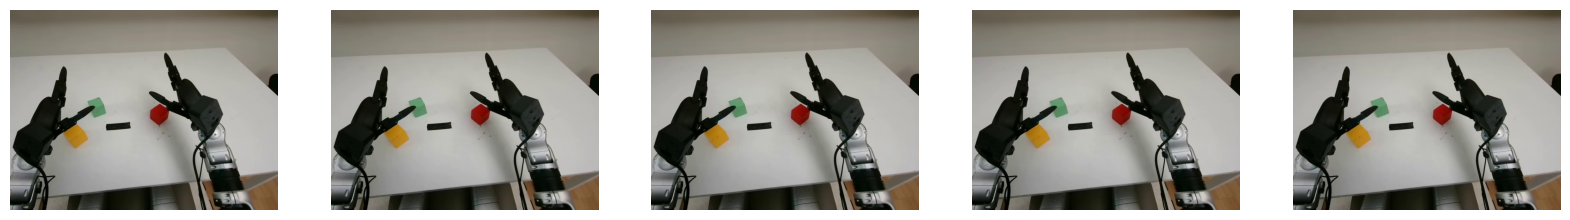

In [ ]:
# use matplotlib to visualize the images
import matplotlib.pyplot as plt
import numpy as np

print(train_dataset[0].keys())

images = []
for i in range(5):
    image = train_dataset[i]["video.cam_right_high"][0]
    # image is in HWC format, convert it to CHW format
    image = image.transpose(2, 0, 1)
    images.append(image)   

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(images):
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis("off")
plt.show()

Now, we will initiate a dataset with our modality configs and transforms.

In [ ]:
train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
    transforms=to_apply_transforms,
)

Initialized dataset g1 with EmbodimentTag.NEW_EMBODIMENT


**Extra Notes**:
 - We use a cached dataloader to accelerate training speed. The cached dataloader loads all data into memory, which significantly improves training performance. However, if your dataset is large or you're experiencing out-of-memory (OOM) errors, you can switch to the standard lerobot dataloader (`gr00t.data.dataset.LeRobotSingleDataset`). It uses the same API as the cached dataloader, so you can switch back and forth without any changes to your code.
 - we use torchvision_av as the video backend, the video encoding is in av instead of standard h264


### Step 2: Load the model

The training process is done in 3 steps:
- 2.1: Load the base model from HuggingFace or a local path
- 2.2: Prepare training args
- 2.3: Run the training loop

#### Step 2.1 Load the base model

We'll use the `from_pretrained_for_tuning` method to load the model. This method allows us to specify which parts of the model to tune.

In [ ]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from gr00t.model.gr00t_n1 import GR00T_N1

BASE_MODEL_PATH = "nvidia/GR00T-N1-2B"
TUNE_LLM = False            # Whether to tune the LLM
TUNE_VISUAL = True          # Whether to tune the visual encoder
TUNE_PROJECTOR = True       # Whether to tune the projector
TUNE_DIFFUSION_MODEL = True # Whether to tune the diffusion model

model = GR00T_N1.from_pretrained(
    pretrained_model_name_or_path=BASE_MODEL_PATH,
    tune_llm=TUNE_LLM,  # backbone's LLM
    tune_visual=TUNE_VISUAL,  # backbone's vision tower
    tune_projector=TUNE_PROJECTOR,  # action head's projector
    tune_diffusion_model=TUNE_DIFFUSION_MODEL,  # action head's DiT
)

# Set the model's compute_dtype to bfloat16
model.compute_dtype = "bfloat16"
model.config.compute_dtype = "bfloat16"
model.to(device)

#### Step 2.2 Prepare training args

We use huggingface `TrainingArguments` to configure the training process. Here are the main parameters:

In [ ]:
from transformers import TrainingArguments

output_dir = "output/model/path"    # CHANGE THIS ACCORDING TO YOUR LOCAL PATH
per_device_train_batch_size = 8     # CHANGE THIS ACCORDING TO YOUR GPU MEMORY
max_steps = 20                      # CHANGE THIS ACCORDING TO YOUR NEEDS
report_to = "wandb"
dataloader_num_workers = 8

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=None,
    remove_unused_columns=False,
    deepspeed="",
    gradient_checkpointing=False,
    bf16=True,
    tf32=True,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=1,
    dataloader_num_workers=dataloader_num_workers,
    dataloader_pin_memory=False,
    dataloader_persistent_workers=True,
    optim="adamw_torch",
    adam_beta1=0.95,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    learning_rate=1e-4,
    weight_decay=1e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    logging_steps=10.0,
    num_train_epochs=300,
    max_steps=max_steps,
    save_strategy="steps",
    save_steps=500,
    evaluation_strategy="no",
    save_total_limit=8,
    report_to=report_to,
    seed=42,
    do_eval=False,
    ddp_find_unused_parameters=False,
    ddp_bucket_cap_mb=100,
    torch_compile_mode=None,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Step 2.3 Initialize the training runner and run the training loop

In [ ]:
from gr00t.experiment.runner import TrainRunner

experiment = TrainRunner(
    train_dataset=train_dataset,
    model=model,
    training_args=training_args,
)

experiment.train()

We can see the 1k offline validation results vs 10k offline validation results:

**Finetuning Results on Unitree G1 Block Stacking Dataset:**

| 1k Steps | 10k Steps |
| --- | --- |
| ![1k](../media/g1_ft_1k.png) | ![10k](../media/g1_ft_10k.png) |
| MSE: 0.0181 | MSE: 0.0022 |